Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 620.2696 - mae: 22.5490 - val_loss: 515.2630 - val_mae: 20.7211
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 539.4170 - mae: 20.6905 - val_loss: 445.5368 - val_mae: 18.9819
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 457.5542 - mae: 18.4224 - val_loss: 383.6109 - val_mae: 17.3959
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 395.2365 - mae: 16.9439 - val_loss: 327.3215 - val_mae: 15.9924
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 330.3442 - mae: 14.9730 - val_loss: 271.3047 - val_mae: 14.4988
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 271.8636 - mae: 13.7635 - val_loss: 217.9785 - val_mae: 12.8962
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 254.8548 - mae: 13.2280 - val_loss: 165.1224 - val_mae: 11.0971
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 159.4485 - mae: 10.6176 - val_loss: 117.7444 - val_mae: 9.2376
Epoch 9/

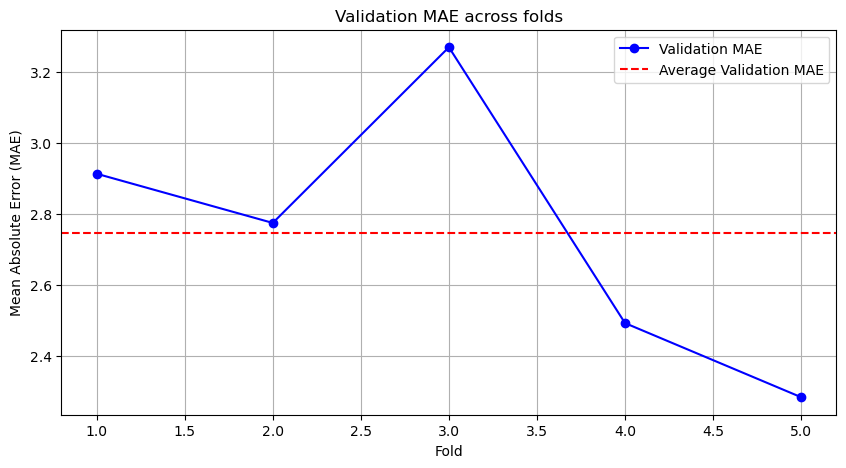

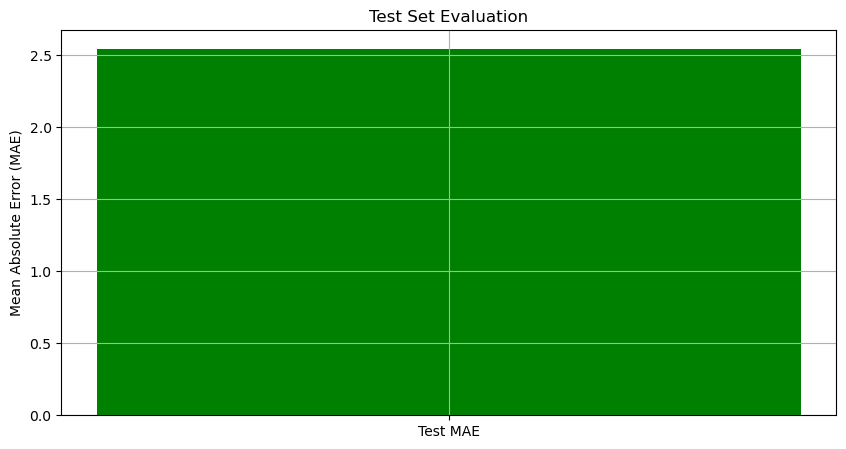

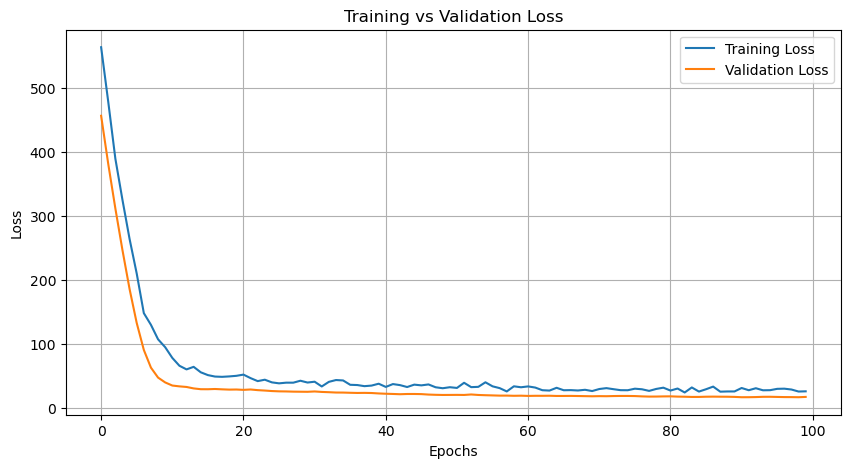

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# Load dataset properly (space-separated format)
file_path = "housing.csv"  # Update this if needed
column_names = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO",
    "B", "LSTAT", "MEDV"  # MEDV (Median Value of homes) is the target variable
]

# Read the dataset
df = pd.read_csv(file_path, delim_whitespace=True, names=column_names)

# Split features (X) and target (y)
X = df.drop(columns=["MEDV"]).values  # Features
y = df["MEDV"].values  # Target variable (house prices)

# Standardize input features (important for NN stability)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Neural Network model
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dropout(0.2),
        layers.Dense(1, activation='linear')  # Linear output for regression
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, clipvalue=1.0),
                  loss='mse',
                  metrics=['mae'])
    return model

# Perform k-Fold Cross-Validation (k=5)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_scores = []

for train_idx, val_idx in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    model = build_model()
    model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32, validation_data=(X_val_fold, y_val_fold), verbose=1)
    
    # Evaluate performance
    score = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    fold_scores.append(score[1])  # Mean Absolute Error (MAE)

print(f'Average Validation MAE across folds: {np.mean(fold_scores):.4f}')

# Final training on the full training dataset
final_model = build_model()
history = final_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate on test set
test_score = final_model.evaluate(X_test, y_test, verbose=0)
print(f'Test MAE: {test_score[1]:.4f}')

# Plot MAE for each fold
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(fold_scores) + 1), fold_scores, marker='o', linestyle='-', color='b', label='Validation MAE')
plt.axhline(y=np.mean(fold_scores), color='r', linestyle='--', label='Average Validation MAE')
plt.xlabel('Fold')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Validation MAE across folds')
plt.legend()
plt.grid(True)
plt.show()

# Plot final test set evaluation
plt.figure(figsize=(10, 5))
plt.bar(['Test MAE'], [test_score[1]], color='g')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Test Set Evaluation')
plt.grid(True)
plt.show()

# Plot training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()